In [1]:
import matplotlib.pyplot as plt
import os
import cv2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Ruta de la carpeta con imágenes
folder_path = "./images"

In [3]:
images = [f for f in os.listdir(folder_path)]
print(images)

['donald-sultan_apples-and-oranges-1987.jpg', 'aldemir-martins_green-vase-with-flowers-and-fruit-2001.jpg', 'albert-gleizes_femme-cubiste-1921.jpg', 'afro_abstract-composition-1975.jpg']


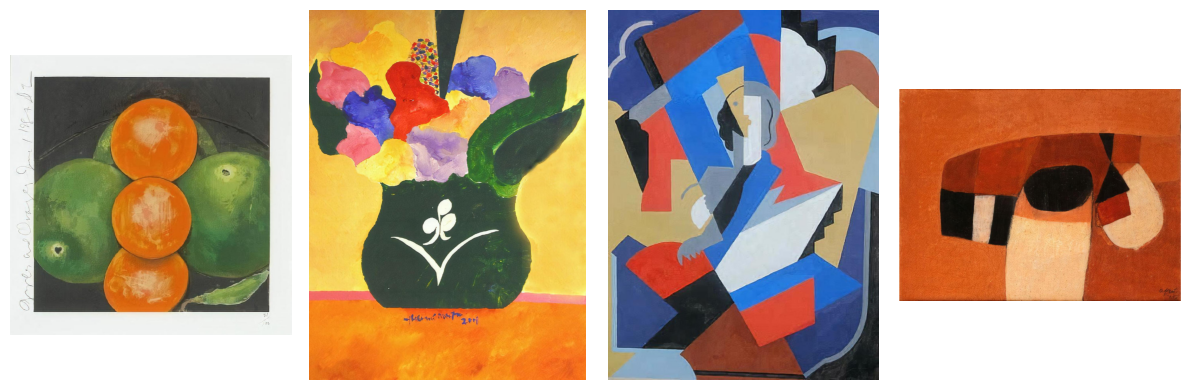

In [7]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
# Cargar y mostrar cada imagen en la grilla
for ax, img_file in zip(axes, images):
    img = cv2.imread(os.path.join(folder_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")  # Ocultar ejes

plt.tight_layout()
plt.show()

In [15]:
# Lista para almacenar los píxeles de todas las imágenes
datos_pixeles = []

# Cargar todas las imágenes en la carpeta
for archivo in os.listdir(folder_path):
    img_path = os.path.join(folder_path, archivo)
    
    # Leer la imagen
    img = cv2.imread(img_path)

    # Redimensionar la imagen al tamaño estándar
    img = cv2.resize(img, (500,500))
    
    # Convertir de BGR a RGB (porque OpenCV carga en BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convertir la imagen en una matriz de píxeles (alto*ancho, 3)
    pixeles = img.reshape(-1, 3)  # -1 para mantener la cantidad total de píxeles
    
    # Guardar los píxeles en la lista
    datos_pixeles.append(pixeles)

# Convertir la lista en un array numpy
datos_pixeles = np.vstack(datos_pixeles)  # Une todos los píxeles en una sola matriz

print(f"Forma de la matriz de píxeles: {datos_pixeles.shape}")  # Debería ser (N, 3)

Forma de la matriz de píxeles: (1000000, 3)


In [17]:
# Normalizar los valores RGB al rango [0, 1]
datos_pixeles = datos_pixeles / 255.0

print(f"Forma de la matriz de píxeles: {datos_pixeles.shape}")  # Debería ser (N, 3)
print(f"Ejemplo de valores normalizados: {datos_pixeles[:5]}")  # Muestra 5 píxeles normalizados

Forma de la matriz de píxeles: (1000000, 3)
Ejemplo de valores normalizados: [[0.80392157 0.81568627 0.78823529]
 [0.96470588 0.97254902 0.95294118]
 [0.94117647 0.94901961 0.93333333]
 [0.94901961 0.95686275 0.94901961]
 [0.95686275 0.96470588 0.96078431]]


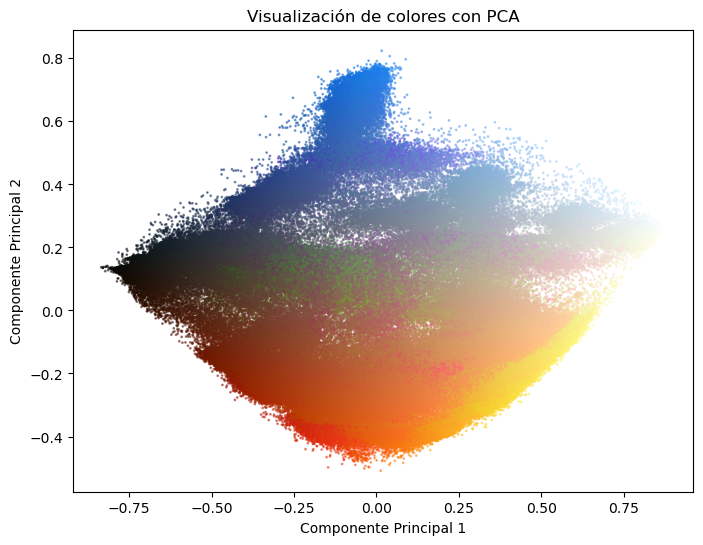

In [19]:
# Aplicar PCA para reducir de 3D (RGB) a 2D
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(datos_pixeles)

# Graficar los datos reducidos
plt.figure(figsize=(8, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], s=1, c=datos_pixeles, alpha=0.5)
plt.title("Visualización de colores con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

In [ ]:
# Invertir PCA para recuperar los datos en el espacio original
x_recovered = pca.inverse_transform(x_reduced)

# Desnormalizar los valores (volver de [0,1] a [0,255])
x_recovered = (x_recovered * 255).astype(np.uint8)

num_imagenes = len(os.listdir(folder_path))
tamaño_img = (250, 250, 3)

# Separar los datos reconstruidos en imágenes individuales
imagenes_recuperadas = np.split(x_recovered, num_imagenes)  

# Mostrar algunas imágenes reconstruidas
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(imagenes_recuperadas[i].reshape(tamaño_img))
    plt.axis("off")
plt.suptitle("Imágenes después de aplicar e invertir PCA")
plt.show()
